<a href="https://colab.research.google.com/github/scotthou94/applied_deep_learning/blob/master/sh3658_hw4_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  323k  100  323k    0     0  56059      0  0:00:05  0:00:05 --:--:-- 75288
name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


In [5]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), float(row[1]) / 255.0, float(row[2]) / 255.0, float(row[3]) / 255.0
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 0.6823529411764706, 0.7137254901960784, 0.3411764705882353)


In [0]:
names = [item[0] for item in colors_rgb]

In [7]:
names[:10]

['parakeet',
 'saddle brown',
 'cucumber crush',
 'pool blue',
 'distance',
 'light urple',
 'east side',
 'florida seashells',
 'paris',
 'powder blush']

In [0]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = pad_sequences(tokenized, maxlen=maxlen)
padded_names = padded_names.astype('float32')

In [9]:
padded_names.shape

(14157, 25)

In [0]:
r = [item[1] for item in colors_rgb]
g = [item[2] for item in colors_rgb]
b = [item[3] for item in colors_rgb]
targets = np.column_stack([r, g, b])

In [11]:
targets.shape

(14157, 3)

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
# Lets stack two layers of gru together
model.add(tf.keras.layers.CuDNNGRU(128, return_sequences=True))
model.add(tf.keras.layers.CuDNNGRU(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=5e-3), loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 25)             0         
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (None, 1, 128)            59520     
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 167,043
Trainable params: 167,043
Non-trainable params: 0
_________________________________________________________________


In [13]:
# we're going to massively overfit on the training
# data... that's fine for this experiment
history = model.fit(padded_names, targets, epochs=5, validation_split=0.1)

Epoch 1/5
399/399 [==============================] - 15s 37ms/step - loss: 0.0636 - acc: 0.6078 - val_loss: 0.0632 - val_acc: 0.6540
Epoch 2/5
399/399 [==============================] - 12s 31ms/step - loss: 0.0605 - acc: 0.6516 - val_loss: 0.0626 - val_acc: 0.6525
Epoch 3/5
399/399 [==============================] - 12s 31ms/step - loss: 0.0589 - acc: 0.6639 - val_loss: 0.0623 - val_acc: 0.6638
Epoch 4/5
399/399 [==============================] - 12s 31ms/step - loss: 0.0579 - acc: 0.6638 - val_loss: 0.0620 - val_acc: 0.6709
Epoch 5/5
399/399 [==============================] - 12s 31ms/step - loss: 0.0567 - acc: 0.6632 - val_loss: 0.0604 - val_acc: 0.6638


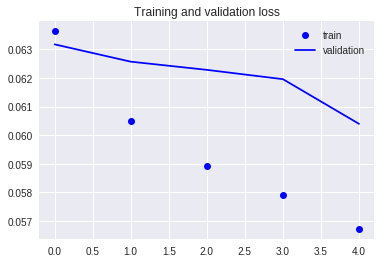

In [14]:
# let's see how badly we've overfit
# (don't worry about it for this assignment)
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.legend(['train', 'validation'], loc='upper right')
plt.title('Training and validation loss')
plt.show()

In [0]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [0]:
def scale(n):
    return int(n * 255)

In [0]:
def predict(name):
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    padded = padded.astype('float32')
    pred = model.predict(np.array(padded))[0]
    # Check the shapes here if you run into trouble with the next 
    # method after adding your RNN
    print(pred)
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

[0.51013917 0.6449792  0.37792304]
light green, R,G,B: 130 164 96


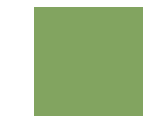

[0.58261985 0.6213735  0.5069219 ]
green, R,G,B: 148 158 129


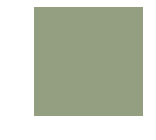

[0.5017475  0.6372033  0.41786808]
dark green, R,G,B: 127 162 106


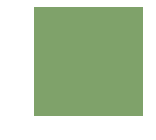

[0.7047797 0.6124957 0.5402826]
burgundy, R,G,B: 179 156 137


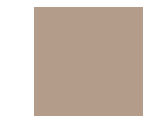

[0.32139033 0.5374769  0.7077899 ]
columbia blue, R,G,B: 81 137 180


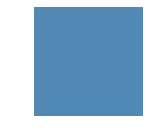

In [18]:
# some "test" data
predict("light green")
predict("green")
predict("dark green")
predict("burgundy")
predict("columbia blue")